# AirBnB Listings by Reputation and Description
by [Talha Oz](http://talhaoz.com)

## Abstract

Reviewing is a feedback mechanism that e-commerce sites leverage to help their customers make more informative purchase decisions on their platforms. Although the biggest online sellers such as Amazon and eBay allow their users to filter the search results by seller reputations, the leading space sharing platform AirBnB lacks this crucial feature. Even more disappointingly, AirBnB does not allow it’s users to search for keywords within listing contents (descriptions). In this project, I create a demo geo-web application to meet these needs of AirBnB users. The application allows its users i) to filter the listings by review scores for six reputation categories, ii) to search in listing descriptions, and iii) to experience better visualization by adopting a different marker for each listing room type and by providing clustered-listings view. I demonstrate the application for the Washington, D.C. area by utilizing a publicly available AirBnB listings dataset.

In [1]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
colpal = sns.color_palette("hls", 7)
sns.set(palette=colpal, style='ticks', rc={"figure.figsize":(7.75,5),'savefig.dpi':150})

import folium
from IPython.display import HTML

## INTRODUCTION
AirBnB is one of the greatest success stories of sharing economy, a website of value $25.5 billion as of November 2015 [1] where hosts provide lodging spaces and guests rent them. Hosts basically rent three types of spaces using this platform: `entire home`, `private room`, and `shared room`. In return of the quality they received during their rental, guests then leave feedback, some of which is public, to the hosts. In addition to the option of free text comments, AirBnB provides six review categories where guests can rate their experience from zero to five (in 0.5 incremental steps). This richness of feedback types is very valuable as trust is of great importance in the sharing economy.

One of the main parts, if not the main part, of listings on AirBnB website is the free-text `description` section where hosts strive for describing their property as attractive as possible. Surprisingly though, currently the website does not allow for searching in it.

It is unfortunate that the guests can see the listing descriptions as well as the review scores, while not being able to narrow their search exploiting this information. In this project I create a geo-web application to overcome this problem. 
In this report, I first introduce AirBnB and describe the purpose of my demo geo-web application in this (Introduction) section. In the next (Data) section I then provide some of the characteristics of the dataset on which I built this demo application. The third section is about the Design of the application where I discuss it under two subsections as Back End and Front End. I then conclude the report with Conclusion and Discussion section. Tables and code snippets are added to appendices whenever found necessary. 


## Data

In [2]:
# read data in 
df = pd.read_csv('data/listings.csv',index_col='id')
print('Number of records:',df.shape[0])
print('Number of columns:',df.shape[1])
print(', '.join(df.columns)) #see the columns starting with review_score...

Number of records: 3723
Number of columns: 91
listing_url, scrape_id, last_scraped, name, summary, space, description, experiences_offered, neighborhood_overview, notes, transit, thumbnail_url, medium_url, picture_url, xl_picture_url, host_id, host_url, host_name, host_since, host_location, host_about, host_response_time, host_response_rate, host_acceptance_rate, host_is_superhost, host_thumbnail_url, host_picture_url, host_neighbourhood, host_listings_count, host_total_listings_count, host_verifications, host_has_profile_pic, host_identity_verified, street, neighbourhood, neighbourhood_cleansed, neighbourhood_group_cleansed, city, state, zipcode, market, smart_location, country_code, country, latitude, longitude, is_location_exact, property_type, room_type, accommodates, bathrooms, bedrooms, beds, bed_type, amenities, square_feet, price, weekly_price, monthly_price, security_deposit, cleaning_fee, guests_included, extra_people, minimum_nights, maximum_nights, calendar_updated, has_ava

### Source
AirBnB (as of December 1, 2015) does not provide a publicly accessible application programming interface (API) for developers to collect information about the listings on their platform. However, enthusiastic hackers have managed to collect the listing data by implementing web scrapers (a search of ‘airbnb data’ in GitHub lists some). 

The dataset (`Listing.csv`) being utilized in this study is retrieved from [insideairbnb.com](http://insideairbnb.com/get-the-data.html) website and also made available in the public repository of this project. The original data source provides the date they scraped the listings, which happens to be October 3, 2015 for Washington, DC.


In [3]:
# pre-process the data
revcols = 'host_id	host_listings_count	number_of_reviews	review_scores_rating	review_scores_accuracy	review_scores_cleanliness	review_scores_checkin	review_scores_communication	review_scores_location	review_scores_value'.split('\t')
df = df.dropna(subset=revcols).sort('review_scores_rating',ascending=False)
df = df.rename(columns=dict(zip(revcols[3:],[c.split('_')[-1] for c in revcols[3:]])))
df = df.rename(columns={'neighbourhood_cleansed':'neighborhood'})
revcols = [c.split('_')[-1] for c in revcols[4:]]

### Descriptive Statistics
There are a total of 3723 listings in Washington, D.C area in the dataset. The very first question one might ask is the spatial distribution of these listings. Are people in Georgetown area more willing to host (list) their properties on AirBnB than those in Foggy Bottom? What neighborhoods are leading in the listings count? To be able to answer questions of this kind, I created a table (Appendix A) as well as a map (Figure 1) showing the number of listings per neighborhood.

The AirBnB listings dataset is also attribute rich, Listing.csv has 91 columns (Appendix A), including listing id, name, neighborhood, room type, description, latitude, longitude, host id, host listings count, number of reviews, and review scores. Other than the total review score, each listing reviewed has scores of six review categories: accuracy, check-in, cleanliness, communication, location, and value. Then one might wonder what the average review score for each category is. For all of the six categories, I found that (Figure 2) the guest satisfaction in general is very high; value and cleanliness are the lowest two with 9.32 and 9.33 respectively, and communication is the highest with 9.75 (One of course from these results should not interpolate that the hosts in the capital are good communicators but dirty, just as the main theme of the city, the politics itself). I should note that only 2846 listings of 3723 are reviewed at least once.

For data management operations, Python’s Pandas library [7] is used, and for visualization Folium [4] and Seaborn [8] exploited.

In [4]:
# number of listings per neighborhood
grouped = pd.DataFrame(df.pivot_table(index='neighborhood',values='rating',aggfunc='count')).sort('rating',ascending=False).reset_index()
grouped # Appendix A

,neighborhood,rating
0,"Columbia Heights, Mt. Pleasant, Pleasant Plain...",351
1,"Dupont Circle, Connecticut Avenue/K Street",285
2,"Capitol Hill, Lincoln Park",242
3,"Shaw, Logan Circle",239
4,"Union Station, Stanton Park, Kingman Park",234
5,"Edgewood, Bloomingdale, Truxton Circle, Eckington",194
6,"Kalorama Heights, Adams Morgan, Lanier Heights",183
7,"Brightwood Park, Crestwood, Petworth",140
8,"Downtown, Chinatown, Penn Quarters, Mount Vern...",135
9,"Howard University, Le Droit Park, Cardozo/Shaw",114


In [5]:
# number of listings per neighborhood
mapname= 'neighborhoods'
m = folium.Map(location=[38.92,-77.03], zoom_start=12, tiles='OpenStreetMap')
m.geo_json(geo_path='neighbourhoods.geojson', data=grouped, data_out=mapname+'.json',
            columns=['neighborhood','rating'],
            key_on='feature.properties.neighbourhood',
            fill_color='PuRd', fill_opacity=0.7, line_opacity=0.2,
            legend_name='AirBnB listings per neighborhood')
m.create_map(path=mapname+'.html')
HTML('<iframe src='+mapname+'.html style="width: 100%; height: 500px; border: none"></iframe>')

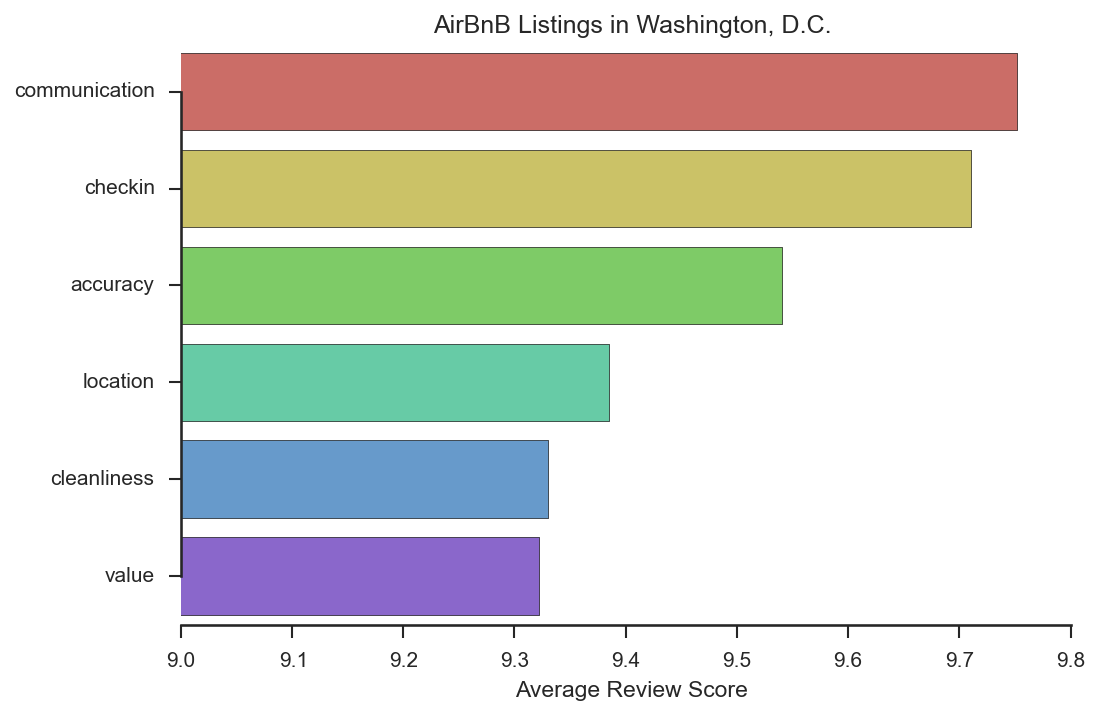

In [6]:
# describe the data
dd = (df[revcols].sum()/len(df)).order(ascending=False)
ax = sns.barplot(y=dd.index,x=dd.values)
#ax = dd.order().plot(kind='barh',color=sns.color_palette('hls'),figsize=(5,3))
ax.set(xlim=(9,9.81),xlabel='Average Review Score',title='AirBnB Listings in Washington, D.C.');
sns.despine(trim=True)
plt.gcf().savefig('docs/review_scores.png',bbox_inches='tight')

In [7]:
df.shape

(2846, 91)

In [8]:
#export related fields to a csv file
df[revcols] = df[revcols].astype(int)
df[['host_id']+revcols+['number_of_reviews','listing_url','name','neighborhood','room_type','description','latitude','longitude']].to_csv('data/reviewed_listings.csv',encoding='utf8')

## Design
A typical web application stack consists of a database server, a web server, a server-side web application framework, and front-end libraries (JS/CSS). A geo-web app on the other hand requires specific technologies and configuration.

## Back End
On the server-side a geo-web app needs to store, operate on and communicate spatial data types effectively. First, regarding spatial data storage and operations, PostgreSQL along with its PostGIS extension allows keeping the data in various geometry types including Polygon and Point. Therefore, I import all the listings reviewed in the Listing.csv data file along with the more related columns (selected columns and rows can also be found in a file named reviewed_listings.csv in the repository) to my application into a PostgreSQL database (see Appendix B for the database schema), and create a new column  of type geometry to keep and operate on the listing coordinates in a single column as points. For full text searching I leverage text search functions and operators in PostgreSQL [6].

Second, to communicate the geospatial data better, I make us of a web server that is effective in creating responses to spatial client requests such as panning and zooming and that can handle specialized protocols such as WMS and WFS, namely GeoServer. I create a store for connecting to the database, and generate a layer (view) on top of it to be published by the server. The code snippet being used for creating the view is available in Appendix C. Given the parameters, the server configured to create and send JSONP objects over WFS when requested (by the browser).


### Front End
The front end of the application works in the browser and thus heavily depends on JavaScript libraries. The application utilizes Leaflet library [5] for mapping (in particular using its geoJson, Icon, and markerClusterGroup classes) and uses JQuery's ajax method [9] for asynchronous communication. In addition to these, it makes use of a rating plugin built on top of Twitter's Bootstrap library [3], namely Krajee's star-rating plugin (open sourced and [available](https://github.com/kartik-v/bootstrap-star-rating) on GitHub online repository hosting service) [2]. Finally, I use three markers from the Map Icons Collection project to denote the room type of the listings.

When the application is run, it basically shows a map of inquired region, along with some control tools. Since this demo focuses on the Washington, DC area, for the initial settings I set the center of the map accordingly (of latitude and longitudes: ~39, ~-77) with a zoom level enough to show the entire district but not much more.

In [ ]:
# Ratings (stars)...
# <input id="cleanliness" class="rating" data-min="0" data-max="5" data-step="0.5" data-size="xs"
#  data-default-caption="{rating} clean" data-clear-caption="Cleanliness" data-star-captions="{}">

# onclick...
function change() {
    var query = document.getElementById('myTextField').value;
    var cleanliness = $('#cleanliness').val()*2;
    var accuracy = $('#accuracy').val()*2;
    var communication = $('#communication').val()*2;
    var checkin = $('#checkin').val()*2;
    var loc = $('#loc').val()*2;
    var val = $('#val').val()*2;
    console.log(cleanliness);
    if (query.length == 0) {
        alert('Nothing to search for...');
        return;
    }
    group.removeLayer(geojsonlayer);
    viewparam = {
        viewparams: "word:" + query +
        ";cleanliness:" + cleanliness +
        ";accuracy:" + accuracy +
        ";communication:" + communication +
        ";checkin:" + checkin +
        ";loc:" + loc +
        ";val:" + val
    };
    parameters = L.Util.extend(defaultParameters, viewparam);
    URL = owsrootUrl + L.Util.getParamString(parameters);
    console.log("Geoserver URL: " + URL);
    queryWFS(URL);
}

In [10]:
# and the demo...
HTML('<video controls><source src="AirBnB.webm" type="video/webm"></video>')

## Conclusion
Utilizing an effective geo-web app development stack, the demo application extends upon AirBnB website. The contributions are three-fold, the application allows its users i) to filter the listings by review scores for six reputation categories by clicking on the star ratings, ii) to search in listing descriptions by entering a key phrase into the search box, and iii) to experience better visualization by adopting a different marker for each listing room type and by providing clustered-listings views.  

## References

1.	Airbnb, Inc. - Financial Report | Annual Revenue | Stock: http://www.privco.com/private-company/airbnb. 
1.	Bootstrap Star Rating - © Kartik: http://plugins.krajee.com/star-rating
1.	Bootstrap · The world’s most popular mobile-first and responsive front-end framework.: http://getbootstrap.com/. 
1.	Folium: Python Data. Leaflet.js Maps. — Folium 0.1.2 documentation: http://folium.readthedocs.org/en/latest/. 
1.	Leaflet — an open-source JavaScript library for interactive maps: http://leafletjs.com/. 
1.	PostgreSQL 9.1: Text Search Functions and Operators: http://www.postgresql.org/docs/9.1/static/functions-textsearch.html.
1.	Python Data Analysis Library — pandas: Python Data Analysis Library: http://pandas.pydata.org/index.html.
1.	Seaborn: statistical data visualization — seaborn 0.6.0 documentation: https://stanford.edu/~mwaskom/software/seaborn
1.	jQuery.ajax() | jQuery API Documentation.

### Appendix B
```CREATE TABLE listings (
    id integer PRIMARY KEY,
    host_id integer,
    accuracy integer,
    cleanliness integer,
    checkin integer,
    communication integer,
    location integer,
    value integer,
    number_of_reviews integer,
    listing_url character varying(50),
    name character varying(50),
    neighborhood character varying(100),
    room_type character varying(15),
    description character varying(1000),
    latitude double precision,
    longitude double precision
);```

I copied the records in the CSV file to this table using the `copy` command in postgres:
`copy listings from 'reviewed_listings.csv' DELIMITERS ',' CSV HEADER;`
Latitute and longitude data (which was imported as `double precision`) are now to be converted to PostGIS geometry (point) object with the following code:

`alter table listings add column the_geom geometry;`

`update listings set the_geom = ST_GeomFromText('POINT(' || longitude || ' ' || latitude || ')',4326);`

### Appendix C
Using default connection settings, I first connected my PostGIS database to GeoServer (called `store` on this side), and named this `store` after the database `airbnb` ([instructions](http://docs.geoserver.org/stable/en/user/data/database/postgis.html)). 

Then, I created the `layer`/`view` named `dc` where I set my default search term as `Potomac` and rating values set to zero ([instructions](https://github.com/boundlessgeo/workshops/blob/master/tutorials/wordmap/src/index.rst#define-the-sql-view)):

```SELECT name,listing_url,room_type,cleanliness,accuracy,communication,checkin,location,value,number_of_reviews,the_geom
FROM listings
WHERE
 (to_tsvector(description) @@
 to_tsquery(regexp_replace(trim('%word%'), E'\\s+', '&', 'g')))
 and cleanliness >= cast('%cleanliness%' as integer)
 and accuracy >= cast('%accuracy%' as integer)
 and communication >= cast('%communication%' as integer)
 and checkin >= cast('%checkin%' as integer)
 and location >= cast('%loc%' as integer)
 and value >= cast('%val%' as integer)```